In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [39]:
def preprocess_databatch(databatch,type="client"):
    if type == "client":
        y_diff = databatch["y_diff"]
        batch_size = y_diff.shape[0]
        image_ = y_diff.reshape(batch_size,-1).float()
    elif type == "simulations":
        y_diff = databatch["nds"]
        batch_size = y_diff.shape[0]
        image_ = y_diff.reshape(batch_size,-1).float()
    
    return image_


# Train the autoencoder
def train_autoencoder(model, data_loader, num_epochs, batch_size,type):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for batch in data_loader.train():
            
            
            inputs = preprocess_databatch(batch,type)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

In [ ]:
# Generate random data for training (including both in-distribution and out-of-distribution samples)
in_distribution_data = torch.randn(1000, 10)  # In-distribution samples
out_of_distribution_data = torch.randn(200, 10)  # Out-of-distribution samples

# Concatenate the data
train_data = torch.cat((in_distribution_data, out_of_distribution_data), dim=0)

# Create an instance of the autoencoder model
autoencoder = Autoencoder(input_dim=10, latent_dim=5)

# Train the autoencoder on the data
train_autoencoder(autoencoder, train_data, num_epochs=50, batch_size=32)

# Evaluate the reconstruction error on test data
test_data = torch.randn(100, 10)  # Test samples (can include both in-distribution and out-of-distribution)
with torch.no_grad():
    reconstructions = autoencoder(test_data)
    mse_loss = nn.MSELoss(reduction='none')
    errors = torch.mean(mse_loss(reconstructions, test_data), dim=1)

# Set a threshold for anomaly detection
threshold = torch.mean(errors) + 2 * torch.std(errors)

# Perform OOD detection
ood_indices = torch.where(errors > threshold)[0]
in_distribution_indices = torch.where(errors <= threshold)[0]

print("Out-of-Distribution Samples:")
print(ood_indices)
print("In-Distribution Samples:")
print(in_distribution_indices)


In [5]:
from clients_dataloaders import BaseDataLoader

In [6]:
import os
import pickle

with open("./data/client_.cp","rb") as file:
    clients_data = pickle.load(file)
    #clients_data["y_diff"] = torch.Tensor(clients_data["y_diff"])
with open("./data/simulations_.cp","rb") as file:
    simulations_data = pickle.load(file)
    #simulations_data["nds"] = torch.Tensor(simulations_data["nds"])

client_data_loader = BaseDataLoader(clients_data,type="client")
simulations_data_loader = BaseDataLoader(simulations_data,type="simulations")

['names', 'y_diff', 'PoDm_dist']
y_diff
['nds', 'PoDmD', 'name']
nds


In [7]:
client_databatch = next(client_data_loader.train().__iter__())
simulations_databatch = next(simulations_data_loader.train().__iter__())

C:\Users\ceoj10\.conda\envs\domain\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [31]:
y_diff = client_databatch["y_diff"]
batch_size = y_diff.shape[0]
image_ = y_diff.reshape(batch_size,-1)
input_dim = image_.shape[-1]

In [41]:
# Create an instance of the autoencoder model
client_autoencoder = Autoencoder(input_dim=input_dim, latent_dim=2)
simulations_autoencoder = Autoencoder(input_dim=input_dim, latent_dim=2)

In [42]:
train_autoencoder(client_autoencoder, client_data_loader, num_epochs=100, batch_size=batch_size,type="client")

Epoch [1/100], Loss: 0.11415392905473709
Epoch [2/100], Loss: 0.07556220144033432
Epoch [3/100], Loss: 0.048244915902614594
Epoch [4/100], Loss: 0.029142383486032486
Epoch [5/100], Loss: 0.017081640660762787
Epoch [6/100], Loss: 0.01092671137303114
Epoch [7/100], Loss: 0.007999604567885399
Epoch [8/100], Loss: 0.006532140076160431
Epoch [9/100], Loss: 0.005712501239031553
Epoch [10/100], Loss: 0.005088865756988525
Epoch [11/100], Loss: 0.004526894073933363
Epoch [12/100], Loss: 0.004024061374366283
Epoch [13/100], Loss: 0.0036221810150891542
Epoch [14/100], Loss: 0.003312811953946948
Epoch [15/100], Loss: 0.003065488999709487
Epoch [16/100], Loss: 0.0028609249275177717
Epoch [17/100], Loss: 0.002679727040231228
Epoch [18/100], Loss: 0.0025085387751460075
Epoch [19/100], Loss: 0.002349376678466797
Epoch [20/100], Loss: 0.0022031106054782867
Epoch [21/100], Loss: 0.0020728041417896748
Epoch [22/100], Loss: 0.0019572474993765354
Epoch [23/100], Loss: 0.0018835942028090358
Epoch [24/100], 

In [43]:
train_autoencoder(simulations_autoencoder, simulations_data_loader, num_epochs=100, batch_size=batch_size,type="simulations")

C:\Users\ceoj10\.conda\envs\domain\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/100], Loss: 0.1039714440703392
Epoch [2/100], Loss: 0.025036843493580818
Epoch [3/100], Loss: 0.011540818959474564
Epoch [4/100], Loss: 0.003717543324455619
Epoch [5/100], Loss: 0.0012048017233610153
Epoch [6/100], Loss: 0.0007856160518713295
Epoch [7/100], Loss: 0.0006663555977866054
Epoch [8/100], Loss: 0.0006077486905269325
Epoch [9/100], Loss: 0.0005753913428634405
Epoch [10/100], Loss: 0.0005557638360187411
Epoch [11/100], Loss: 0.0005386785487644374
Epoch [12/100], Loss: 0.0005096361273899674
Epoch [13/100], Loss: 0.0004964015679433942
Epoch [14/100], Loss: 0.000490263570100069
Epoch [15/100], Loss: 0.00048719410551711917
Epoch [16/100], Loss: 0.00048459743265993893
Epoch [17/100], Loss: 0.00047723250463604927
Epoch [18/100], Loss: 0.0004684028390329331
Epoch [19/100], Loss: 0.00046398761332966387
Epoch [20/100], Loss: 0.000462596770375967
Epoch [21/100], Loss: 0.000461972871562466
Epoch [22/100], Loss: 0.0004621490079443902
Epoch [23/100], Loss: 0.00046147708781063557
E

In [52]:
representations_client_from_client = []
for client_databatch in client_data_loader.train():
    image_ = preprocess_databatch(client_databatch,"client")
    representations_client_from_client.append(client_autoencoder.encoder(image_))
representations_client_from_client = torch.vstack(representations_client_from_client)

representations_simulation_from_client = []
for simulation_databatch in simulations_data_loader.train():
    image_ = preprocess_databatch(simulation_databatch,"simulations")
    representations_simulation_from_client.append(client_autoencoder.encoder(image_))
representations_simulation_from_client = torch.vstack(representations_simulation_from_client)

In [58]:
representations_client_from_simulations = []
for client_databatch in client_data_loader.train():
    image_ = preprocess_databatch(client_databatch,"client")
    representations_client_from_simulations.append(simulations_autoencoder.encoder(image_))
representations_client_from_simulations = torch.vstack(representations_client_from_simulations)

representations_simulation_from_simulation = []
for simulation_databatch in simulations_data_loader.train():
    image_ = preprocess_databatch(simulation_databatch,"simulations")
    representations_simulation_from_simulation.append(simulations_autoencoder.encoder(image_))
representations_simulation_from_simulation = torch.vstack(representations_simulation_from_simulation)

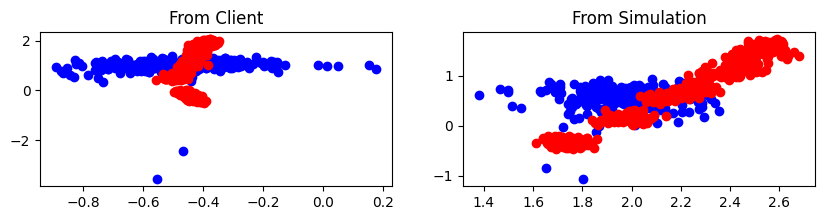

In [63]:
from matplotlib import pyplot as plt

Xcc = representations_client_from_client[:,0].detach().numpy()
Ycc = representations_client_from_client[:,1].detach().numpy()

Xsc = representations_simulation_from_client[:,0].detach().numpy()
Ysc = representations_simulation_from_client[:,1].detach().numpy()

Xcs = representations_client_from_simulations[:,0].detach().numpy()
Ycs = representations_client_from_simulations[:,1].detach().numpy()

Xss = representations_simulation_from_simulation[:,0].detach().numpy()
Yss = representations_simulation_from_simulation[:,1].detach().numpy()


fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10,2))

ax[0].set_title("From Client")
ax[0].plot(Xcc,Ycc,"bo",label="client")
ax[0].plot(Xsc,Ysc,"ro",label="simulations")


ax[1].set_title("From Simulation")
ax[1].plot(Xcs,Ycs,"bo",label="client")
ax[1].plot(Xss,Yss,"ro",label="simulations")

plt.savefig("SimpleAutoEncodingSpace.png")